## Reserve and configure resources on FABRIC

Before you run this experiment, you will:

-   define the specific configuration of resources you need.
-   “instantiate” an experiment with your reserved resources.
-   wait for your resources to be configured.
-   log in to resources to carry out the experiment.

This exercise will guide you through those steps.

### Configure environment

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Orchestrator,orchestrator.fabric-testbed.net
Credential Manager,cm.fabric-testbed.net
Core API,uis.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,7bc05490-ba40-45ba-99dc-b011680825d2
Bastion Host,bastion.fabric-testbed.net
Bastion Username,aacheme_0000078855
Bastion Private Key File,/home/fabric/work/fabric_config/fabric-bastion-key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Sites to avoid,


### Define configuration for this experiment (3 VMs)

For this specific experiment, we will need three virtual machines connected to a common network. Each of the virtual machines will be of the `m1.large` type, with 4 VCPUs, 8 GB memory, 40 GB disk space.

In [2]:
import os
slice_name = "k8s_secure_4" + os.getenv('NB_USER')

node_conf = [
 {'name': "node-0", 'cores': 4, 'ram': 8, 'disk': 40, 'image': 'default_ubuntu_22', 'packages': ["virtualenv"]}, 
 {'name': "node-1", 'cores': 4, 'ram': 8, 'disk': 40, 'image': 'default_ubuntu_22', 'packages': []}, 
 {'name': "node-2", 'cores': 4, 'ram': 8, 'disk': 40, 'image': 'default_ubuntu_22', 'packages': []},
 {'name': "node-3", 'cores': 4, 'ram': 8, 'disk': 40, 'image': 'default_ubuntu_22', 'packages': []}
]
net_conf = [
 {"name": "net0", "subnet": "192.168.1.0/24", "nodes": [{"name": "node-0",   "addr": "192.168.1.10"}, {"name": "node-1", "addr": "192.168.1.11"}, {"name": "node-2", "addr": "192.168.1.12"}, {"name": "node-3", "addr": "192.168.1.13"}]},
]
route_conf = []

exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }


### Reserve resources

Now, we are ready to reserve resources!

First, make sure you don’t already have a slice with this name:

In [3]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named k8s_secure_4aacheme yet.
Continue to the next step to make one.


We will select a site for our experiment that has an IPv4 management network - otherwise, setting up the cluster is more complicated:

In [4]:
site_name = "FIU"
fablib.show_site(site_name)

Name,FIU
State,Active
Address,"11001 SW 14th St,Miami,FL 33199"
Location,"(25.7542948, -80.3702894)"
PTP Capable,True
Hosts,5
CPUs,10
Cores Available,344
Cores Capacity,640
Cores Allocated,296
Ram Available,1214


'<pandas.io.formats.style.Styler object at 0x7f57b45b04d0>'

Then we will add hosts and network segments:

In [5]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [6]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

The following cell submits our request to the FABRIC site. The output of this cell will update automatically as the status of our request changes.

-   While it is being prepared, the “State” of the slice will appear as “Configuring”.
-   When it is ready, the “State” of the slice will change to “StableOK”.

You may prefer to walk away and come back in a few minutes (for simple slices) or a few tens of minutes (for more complicated slices with many resources).

In [7]:
slice.submit()


Retry: 8, Time: 215 sec


ID,fde52e15-fbb6-4d3a-ab2c-0ec4da07259b
Name,k8s_secure_4aacheme
Lease Expiration (UTC),2024-12-11 19:02:26 +0000
Lease Start (UTC),2024-12-10 19:02:26 +0000
Project ID,7bc05490-ba40-45ba-99dc-b011680825d2
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
495c90bd-3201-4e49-8c1b-481f12a30b85,node-0,4,8,100,default_ubuntu_22,qcow2,fiu-w4.fabric-testbed.net,FIU,ubuntu,131.94.57.45,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.45,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
558ba078-46eb-4320-ade2-422714f80f5e,node-1,4,8,100,default_ubuntu_22,qcow2,fiu-w4.fabric-testbed.net,FIU,ubuntu,131.94.57.46,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.46,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
a5e8d440-9933-4e77-8ede-29b6905d0c4a,node-2,4,8,100,default_ubuntu_22,qcow2,fiu-w4.fabric-testbed.net,FIU,ubuntu,131.94.57.39,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.39,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c5eadb2c-b7b2-464d-861b-48b9b3cd7a7e,node-3,4,8,100,default_ubuntu_22,qcow2,fiu-w4.fabric-testbed.net,FIU,ubuntu,131.94.57.53,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.53,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
dabed0cc-33bf-470f-af2f-bce12c7232cd,net0,L2,L2Bridge,FIU,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
node-0-net0-p1,p1,node-0,net0,100,config,,16:0B:08:E7:B2:42,enp7s0,enp7s0,fe80::140b:8ff:fee7:b242,4,HundredGigE0/0/0/11
node-1-net0-p1,p1,node-1,net0,100,config,,1A:62:DE:7D:A8:4E,enp7s0,enp7s0,fe80::1862:deff:fe7d:a84e,4,HundredGigE0/0/0/11
node-2-net0-p1,p1,node-2,net0,100,config,,1E:33:BB:62:94:A4,enp7s0,enp7s0,fe80::1c33:bbff:fe62:94a4,4,HundredGigE0/0/0/11
node-3-net0-p1,p1,node-3,net0,100,config,,22:60:3F:C6:10:CF,enp7s0,enp7s0,fe80::2060:3fff:fec6:10cf,4,HundredGigE0/0/0/11



Time to print interfaces 232 seconds


'fde52e15-fbb6-4d3a-ab2c-0ec4da07259b'

In [8]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

### Configure resources

Next, we will configure the resources so they are ready to use.

In [9]:
slice = fablib.get_slice(name=slice_name)

In [10]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo DEBIAN_FRONTEND=noninteractive apt -y install %s" % pkg)

In [11]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [12]:
# make sure all interfaces are brought up
for iface in slice.get_interfaces():
    iface.ip_link_up()

In [13]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

192.168.1.10 node-0
192.168.1.11 node-1
192.168.1.12 node-2
192.168.1.13 node-3
192.168.1.10 node-0
192.168.1.11 node-1
192.168.1.12 node-2
192.168.1.13 node-3
192.168.1.10 node-0
192.168.1.11 node-1
192.168.1.12 node-2
192.168.1.13 node-3
192.168.1.10 node-0
192.168.1.11 node-1
192.168.1.12 node-2
192.168.1.13 node-3


In [14]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [15]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

### Draw the network topology

The following cell will draw the network topology, for your reference. The interface name and addresses of each experiment interface will be shown on the drawing.

In [16]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

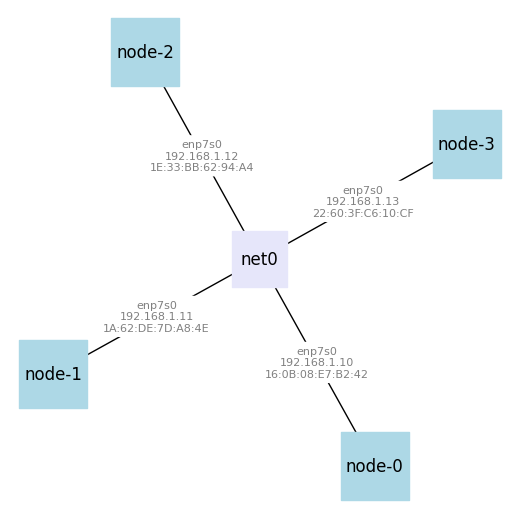

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Use Kubespray to prepare a Kubernetes cluster

Now that are resources are “up”, we will use Kubespray, a software utility for preparing and configuring a Kubernetes cluster, to set them up as a cluster.

In [18]:
# install Python libraries required for Kubespray
remote = slice.get_node(name="node-0")
remote.execute("virtualenv -p python3 myenv")
remote.execute("git clone --branch release-2.22 https://github.com/kubernetes-sigs/kubespray.git")
_ = remote.execute("source myenv/bin/activate; cd kubespray; pip3 install -r requirements.txt")

created virtual environment CPython3.10.12.final.0-64 in 344ms
  creator CPython3Posix(dest=/home/ubuntu/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/ubuntu/.local/share/virtualenv)
    added seed packages: pip==22.0.2, setuptools==59.6.0, wheel==0.37.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
 Cloning into 'kubespray'...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 68.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
# copy config files to correct locations
remote.execute("mv kubespray/inventory/sample kubespray/inventory/mycluster")
remote.execute("git clone https://github.com/teaching-on-testbeds/k8s.git")
remote.execute("cp k8s/config/k8s-cluster.yml kubespray/inventory/mycluster/group_vars/k8s_cluster/k8s-cluster.yml")
remote.execute("cp k8s/config/inventory.py    kubespray/contrib/inventory_builder/inventory.py")
remote.execute("cp k8s/config/addons.yml      kubespray/inventory/mycluster/group_vars/k8s_cluster/addons.yml")

 Cloning into 'k8s'...
 

('', '')

In [20]:
# build inventory for this specific topology
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
physical_ips_str = " ".join(physical_ips)
_ = remote.execute(f"source myenv/bin/activate; declare -a IPS=({physical_ips_str});"+"cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}")


DEBUG: Adding group all
DEBUG: Adding group kube_control_plane
DEBUG: Adding group kube_node
DEBUG: Adding group etcd
DEBUG: Adding group k8s_cluster
DEBUG: Adding group calico_rr
DEBUG: adding host node-0 to group all
DEBUG: adding host node-1 to group all
DEBUG: adding host node-2 to group all
DEBUG: adding host node-3 to group all
DEBUG: adding host node-0 to group etcd
DEBUG: adding host node-1 to group etcd
DEBUG: adding host node-2 to group etcd
DEBUG: adding host node-0 to group kube_control_plane
DEBUG: adding host node-1 to group kube_control_plane
DEBUG: adding host node-0 to group kube_node
DEBUG: adding host node-1 to group kube_node
DEBUG: adding host node-2 to group kube_node
DEBUG: adding host node-3 to group kube_node


In [21]:
# make sure "controller" node can SSH into the others
remote.execute('ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -q -N ""')
public_key, stderr = remote.execute('cat ~/.ssh/id_rsa.pub', quiet=True)

for n in node_conf:
    node = slice.get_node(n['name'])
    print("Now copying key to node " + n['name'])
    node.execute(f'echo {public_key.strip()} >> ~/.ssh/authorized_keys')

Now copying key to node node-0
Now copying key to node node-1
Now copying key to node node-2
Now copying key to node node-3


In [22]:
# build the cluster
_ = remote.execute("source myenv/bin/activate; cd kubespray; ansible-playbook -i inventory/mycluster/hosts.yaml  --become --become-user=root cluster.yml")


PLAY [localhost] ***************************************************************
Tuesday 10 December 2024  19:09:15 +0000 (0:00:00.012)       0:00:00.012 ****** 

TASK [Check 2.11.0 <= Ansible version < 2.13.0] ********************************
ok: [localhost] => {
    "changed": false,
    "msg": "All assertions passed"
}
Tuesday 10 December 2024  19:09:15 +0000 (0:00:00.019)       0:00:00.031 ****** 
 [WARNING]: Skipping callback plugin 'ara_default', unable to load
 
TASK [Check that python netaddr is installed] **********************************
ok: [localhost] => {
    "changed": false,
    "msg": "All assertions passed"
}
Tuesday 10 December 2024  19:09:15 +0000 (0:00:00.053)       0:00:00.085 ****** 

TASK [Check that jinja is not too old (install via pip)] ***********************
ok: [localhost] => {
    "changed": false,
    "msg": "All assertions passed"
}

PLAY [Add kube-master nodes to kube_control_plane] *****************************
skipping: no hosts matched
 [WARNING]: 

In [23]:
# allow kubectl access for non-root user
remote.execute("sudo cp -R /root/.kube /home/ubuntu/.kube; sudo chown -R ubuntu /home/ubuntu/.kube; sudo chgrp -R ubuntu /home/ubuntu/.kube")

('', '')

In [24]:
# check installation
_ = remote.execute("kubectl get nodes")

NAME     STATUS   ROLES           AGE     VERSION
node-0   Ready    control-plane   3m38s   v1.26.5
node-1   Ready    control-plane   3m17s   v1.26.5
node-2   Ready    <none>          2m30s   v1.26.5
node-3   Ready    <none>          2m17s   v1.26.5


### Set up Docker

Now that we have a Kubernetes cluster, we have a framework in place for container orchestration. But we still need to set up Docker, for building, sharing, and running those containers.

In [25]:
# add the user to the "docker" group on all hosts
for n in node_conf:
    node = slice.get_node(n['name'])
    node.execute("sudo groupadd -f docker; sudo usermod -aG docker $USER")

In [26]:
# set up a private distribution registry on the "controller" node for distributing containers
# note: need a brand-new SSH session in order to "get" new group membership
remote.execute("docker run -d -p 5000:5000 --restart always --name registry registry:2")

05de8d045d230b58104efed192ff2cdbfdd10231b20d4f61b4fb0a6e4b5c3ccd
 Unable to find image 'registry:2' locally
2: Pulling from library/registry
dc0decf4841d: Pulling fs layer
6cb0aa443e23: Pulling fs layer
813676e291ef: Pulling fs layer
dc2fb7dcec61: Pulling fs layer
916205650bfe: Pulling fs layer
dc2fb7dcec61: Waiting
916205650bfe: Waiting
6cb0aa443e23: Verifying Checksum
6cb0aa443e23: Download complete
dc2fb7dcec61: Verifying Checksum
dc2fb7dcec61: Download complete
dc0decf4841d: Verifying Checksum
dc0decf4841d: Download complete
dc0decf4841d: Pull complete
916205650bfe: Verifying Checksum
916205650bfe: Download complete
813676e291ef: Verifying Checksum
813676e291ef: Download complete
6cb0aa443e23: Pull complete
813676e291ef: Pull complete
dc2fb7dcec61: Pull complete
916205650bfe: Pull complete
Digest: sha256:543dade69668e02e5768d7ea2b0aa4fae6aa7384c9a5a8dbecc2be5136079ddb
Status: Downloaded newer image for registry:2
 

('05de8d045d230b58104efed192ff2cdbfdd10231b20d4f61b4fb0a6e4b5c3ccd\n',
 "Unable to find image 'registry:2' locally\n2: Pulling from library/registry\ndc0decf4841d: Pulling fs layer\n6cb0aa443e23: Pulling fs layer\n813676e291ef: Pulling fs layer\ndc2fb7dcec61: Pulling fs layer\n916205650bfe: Pulling fs layer\ndc2fb7dcec61: Waiting\n916205650bfe: Waiting\n6cb0aa443e23: Verifying Checksum\n6cb0aa443e23: Download complete\ndc2fb7dcec61: Verifying Checksum\ndc2fb7dcec61: Download complete\ndc0decf4841d: Verifying Checksum\ndc0decf4841d: Download complete\ndc0decf4841d: Pull complete\n916205650bfe: Verifying Checksum\n916205650bfe: Download complete\n813676e291ef: Verifying Checksum\n813676e291ef: Download complete\n6cb0aa443e23: Pull complete\n813676e291ef: Pull complete\ndc2fb7dcec61: Pull complete\n916205650bfe: Pull complete\nDigest: sha256:543dade69668e02e5768d7ea2b0aa4fae6aa7384c9a5a8dbecc2be5136079ddb\nStatus: Downloaded newer image for registry:2\n")

In [27]:
# set up docker configuration on all the hosts
for n in node_conf:
    node = slice.get_node(n['name'])
    node.execute("sudo wget https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json -O /etc/docker/daemon.json")
    node.execute("sudo service docker restart")


 --2024-12-10 19:19:36--  https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Saving to: ‘/etc/docker/daemon.json’

     0K                                                       100% 13.4M=0s

2024-12-10 19:19:36 (13.4 MB/s) - ‘/etc/docker/daemon.json’ saved [65/65]

  --2024-12-10 19:19:50--  https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]

In [28]:
# check configuration
remote.execute("docker run hello-world")


Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
    (amd64)
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker ID:
 https://hub.docker.com/

For more examples and ideas, visit:
 https://docs.docker.com/get-started/

 Unable to find image 'hello-world:latest' locally
latest: Pulling from library/hello-world
c1ec31eb5944: Pulling fs layer
c1ec31eb5944: Download complete
c1ec31eb5944: Pull complete
Digest: sh

('\nHello from Docker!\nThis message shows that your installation appears to be working correctly.\n\nTo generate this message, Docker took the following steps:\n 1. The Docker client contacted the Docker daemon.\n 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.\n    (amd64)\n 3. The Docker daemon created a new container from that image which runs the\n    executable that produces the output you are currently reading.\n 4. The Docker daemon streamed that output to the Docker client, which sent it\n    to your terminal.\n\nTo try something more ambitious, you can run an Ubuntu container with:\n $ docker run -it ubuntu bash\n\nShare images, automate workflows, and more with a free Docker ID:\n https://hub.docker.com/\n\nFor more examples and ideas, visit:\n https://docs.docker.com/get-started/\n\n',
 "Unable to find image 'hello-world:latest' locally\nlatest: Pulling from library/hello-world\nc1ec31eb5944: Pulling fs layer\nc1ec31eb5944: Download complete\nc1ec31

### Get SSH login details

At this point, we should be able to log in to our “controller” node over SSH! Run the following cell, and observe the output - you will see an SSH command this node.

In [29]:
print(remote.get_ssh_command())

ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.45


Now, you can open an SSH session as follows:

-   In Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   Copy the SSH command from the output above, and paste it into the terminal.